In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:
    def __init__(self,val,_children=(),_op='',label=''):
        self.val = val
        self.grad = 0.0
        self._backward = lambda:None
        self._prev = set(_children)
        self._op = _op
        self.label=label
    def __repr__(self):
        return f"Value(data={self.val})"
    def __rsum__(self,other):
        return self + other
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.val + other.val,(self,other),"+")
        def _backward():
            # chain rule
            self.grad += 1.0*out.grad
            other.grad += 1.0*out.grad
        out._backward = _backward
        return out
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.val*other.val,(self,other),"*")
        def _backward():
            # chain rule
            self.grad += other.val*out.grad
            other.grad += self.val*out.grad
        out._backward = _backward
        return out

    # In case mul fails
    def __rmul__(self,other):
        return self*other

    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.val / other.val, (self, other), "/")
        def _backward():
            self.grad += (1.0 / other.val) * out.grad
            other.grad += (-self.val / (other.val ** 2)) * out.grad
        out._backward = _backward
        return out
    def __rtruediv__(self, other):
        return (other if isinstance(other, Value) else Value(other)) / self
    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.val - other.val, (self, other), "-")
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += -1.0 * out.grad
        out._backward = _backward
        return out

    def __rsub__(self, other):
        return (other if isinstance(other, Value) else Value(other)) - self
        
    def __pow__(self,other):
        assert isinstance(other,(int,float))
        out = Value(self.val ** other,(self,),f'**{other}')
        def _backward():
            self.grad = other * (self.val ** (other - 1)) * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.val
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t,(self,),"tanh")
        def _backward():
            # chain rule
            self.grad += (1.0 - t**2)*out.grad
        out._backward = _backward
        return out
    def exp(self):
        x = self.val
        out = Value(math.exp(x),(self,),"exp")
        def _backward():
            # de^x/dy = e^x - v cool, should have known this 4 years back
            self.grad += out.val * out.grad
        out._backward = _backward
        return out
        
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1
        for node in reversed(topo):
            node._backward()




In [3]:
# Viz code
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | val %.4f | grad %.4f }" % (n.label,n.val,n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

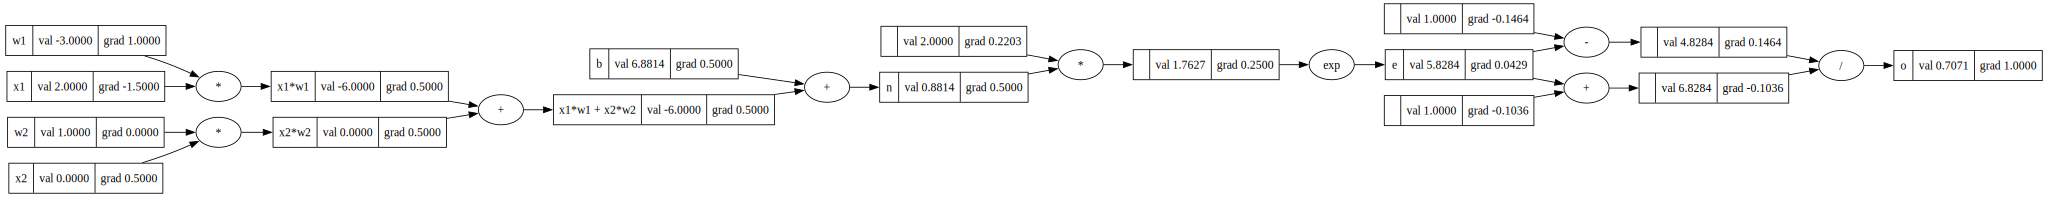

In [96]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp(); e.label = "e"
o = (e - 1) / (e + 1);o.label = "o"
o.backward()
draw_dot(o)


In [8]:
import random
class Neuron:
    def __init__(self,nin):
        # Weights for the NN
        # nin -> inputs
        # create weights for each input
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        # Bias
        self.b = Value(random.uniform(-1,1))
    def __call__(self,x):
        act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b) + self.b
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]
class Layer:
    # nin -> inputs , nout-> number of neurons in the layer
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params
class MLP:
    # multiple nouts
    def __init__(self,nin,nouts):
        szn = [nin] + nouts
        self.layers = [Layer(szn[i],szn[i + 1]) for i in range(len(nouts))]

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x 
    def parameters(self):
        params = []
        for layer in self.layers:
            ps = layer.parameters()
            params.extend(ps)
        return params

x = [2.0,3.0,-1.0]
n = MLP(3,[4,4,1])
n(x)


Value(data=0.8441199108572586)

In [9]:
# 4 possible inputs
xs = [[2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
      [0.5,1.0,1.0],
      [1.0,1.0,-1.0]
     ]
# 4 desired targets
ys = [1.0,-1.0,-1.0,1.0]


In [10]:
for k in range(40):
    # forward pass
    ypred = [n(x) for x in xs]
    squared_diffs = [(yout - ygrd)**2 for yout, ygrd in zip(ypred, ys)]
    loss = sum(squared_diffs, Value(0))
    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    for p in n.parameters():
        p.val += -0.05 * p.grad
    print(k,loss.val)

0 7.715403874788763
1 7.596672565574439
2 7.362130269364921
3 6.812335082204237
4 5.467887452173951
5 4.329495651265239
6 3.9817074525160936
7 3.8841320190938133
8 3.9596881271486484
9 4.371819693322899
10 4.1757309348990574
11 4.488752394880264
12 3.490249605798276
13 4.506947511154703
14 2.4494320461902843
15 3.70604616437238
16 2.296674800307696
17 2.5997547992813925
18 1.3733146637852152
19 0.3599216931133453
20 0.07826242780122912
21 0.06806728461438591
22 0.06177205471015566
23 0.057109508578973865
24 0.053318192607326564
25 0.05008168954328128
26 0.04724450285037593
27 0.04471813872225789
28 0.04244564219509682
29 0.04038673665532596
30 0.038510978845884614
31 0.036794299458932256
32 0.03521708720242318
33 0.033763031804463856
34 0.0324183697895887
35 0.031171360771553122
36 0.030011905425599984
37 0.028931256249481337
38 0.027921792432256377
39 0.026976840963354655


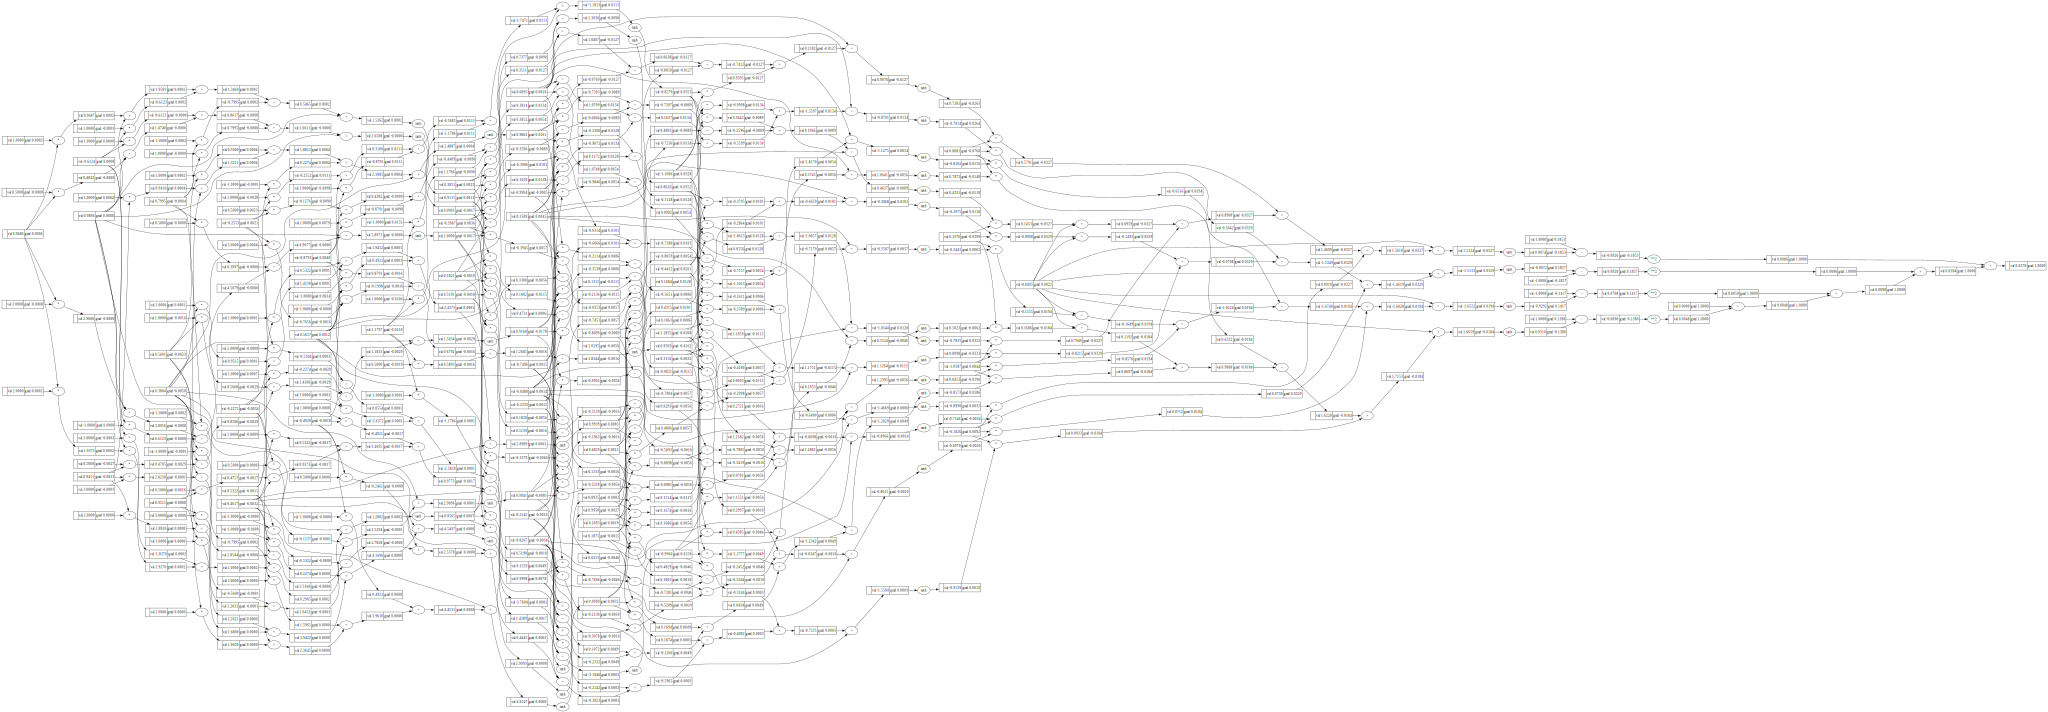

In [11]:
draw_dot(loss)